# Import Libraries

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from keras import Sequential
import tensorflow.keras.layers as tfl
from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping


# Data Exploration

In [2]:
data = pd.read_csv('train.csv')
data.shape

(10407, 4)

In [3]:
num_class = len(data.label.unique())
display("Number of classes:",num_class)

'Number of classes:'

10

In [30]:
base_path = 'dataset/'
diseases = os.listdir(base_path)

label = []
for dis in diseases:
    label.append(dis)

In [31]:
label

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

# Transfer Learning MobileNetV3Large

In [5]:
labels = os.listdir('dataset/')
img_size = 256

train_dataset = image_dataset_from_directory(
    'dataset/',
    image_size = (img_size,img_size),
    batch_size = 64,
    shuffle=True,
    labels='inferred',
    class_names = labels,
    label_mode = 'categorical',
    color_mode='rgb',
    validation_split = 0.1,
    subset='training',
    seed=22
)


val_dataset = image_dataset_from_directory(
    'dataset/',
    image_size = (img_size,img_size),
    batch_size = 64,
    shuffle=False,
    labels='inferred',
    class_names = labels,
    label_mode = 'categorical',
    color_mode='rgb',
    validation_split = 0.1,
    subset='validation',
    seed=22
)

Found 10407 files belonging to 10 classes.
Using 9367 files for training.
Found 10407 files belonging to 10 classes.
Using 1040 files for validation.


In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
transferlearning = tf.keras.applications.MobileNetV3Large(
    include_top=False,
    weights='imagenet',
    input_shape=(256,256,3),
)
for layer in transferlearning.layers:
    layer.trainable = False

In [8]:
model = Sequential()
model.add(transferlearning)
model.add(tfl.Flatten())
model.add(tfl.Dense(1024, activation='relu'))
model.add(tfl.BatchNormalization())
model.add(tfl.Dense(512, activation='relu'))
model.add(tfl.BatchNormalization())
model.add(tfl.Dense(128, activation='relu'))
model.add(tfl.Dropout(0.15))
model.add(tfl.BatchNormalization())
model.add(tfl.Dense(64, activation='relu'))
model.add(tfl.Dropout(0.3))
model.add(tfl.BatchNormalization())
model.add(tfl.Dense(10, activation='softmax'))

In [9]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss',patience=8, verbose=1,  factor=0.4, min_lr=0.0005)
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)

In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 8, 8, 960)        2996352   
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 61440)             0         
                                                                 
 dense (Dense)               (None, 1024)              62915584  
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2

In [12]:
hist = model.fit(train_dataset,
                 validation_data=val_dataset,
                 epochs=5,
                 verbose=1,
                 callbacks=[early_stop])

Epoch 1/5
147/147 [==============================] - 422s 3s/step - loss: 1.0714 - accuracy: 0.6705 - val_loss: 0.3862 - val_accuracy: 0.8846
Epoch 2/5
147/147 [==============================] - 429s 3s/step - loss: 0.2777 - accuracy: 0.9284 - val_loss: 0.0715 - val_accuracy: 0.9817
Epoch 3/5
147/147 [==============================] - 414s 3s/step - loss: 0.0999 - accuracy: 0.9793 - val_loss: 0.0535 - val_accuracy: 0.9885
Epoch 4/5
147/147 [==============================] - 418s 3s/step - loss: 0.0621 - accuracy: 0.9861 - val_loss: 0.0731 - val_accuracy: 0.9856
Epoch 5/5
147/147 [==============================] - 410s 3s/step - loss: 0.0490 - accuracy: 0.9895 - val_loss: 0.0598 - val_accuracy: 0.9865


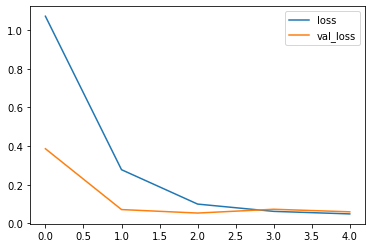

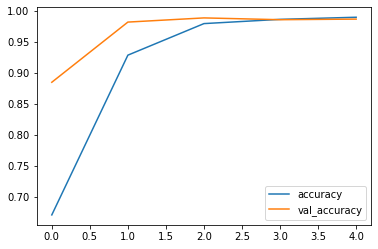

In [13]:
hist = pd.DataFrame(hist.history)
hist.loc[:,['loss','val_loss']].plot()
hist.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

# Predict image using different dataset

In [44]:
predict_img = load_img('data_predict/Tungro/TUNGRO1_001.jpg', target_size = (img_size, img_size))
predict_img = img_to_array(predict_img)
predict_img = np.expand_dims(predict_img, axis = 0)

predict_img2 = load_img('data_predict/Bacterialblight/BACTERAILBLIGHT3_007.jpg', target_size = (img_size, img_size))
predict_img2 = img_to_array(predict_img2)
predict_img2 = np.expand_dims(predict_img2, axis = 0)



pred = model.predict(predict_img)
pred = label[np.argmax(pred)]
print(pred)

pred2 = model.predict(predict_img2)
pred2 = label[np.argmax(pred2)]
print(pred2)

1/1 [==============================] - 0s 147ms/step
tungro
1/1 [==============================] - 0s 72ms/step
dead_heart
